In [2]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import itertools
import scipy
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LogNorm

from produce_dataset import *

In [3]:
ntuple_dir = '/ecoderemdvol/EleGun/EPGun-PU200/data/econ_ntuples/0002/'
root_dir = 'FloatingpointAutoEncoderEMDAEMSEttbarDummyHistomaxGenmatchGenclustersntuple'
#thresh_simenergy: False, read PU wafers too
df_econ = loadEconData(ntuple_dir,root_dir,'econ_data.csv',False)

df_gen = loadGenData(ntuple_dir,root_dir,'gen_data.csv')

In [4]:
df_econ_front_endcap = df_econ[df_econ.zside > 0]

In [5]:
df_econ

,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,ECON_9,...,ECON_14,ECON_15,subdet,zside,layer,waferu,waferv,wafer_energy,tc_eta,tc_phi
0,0,128,0,128,128,0,128,128,192,64,...,64,128,2,-1,50,7,6,0.0,-2.380200,2.320103
1,0,192,0,128,128,0,128,256,192,64,...,64,64,2,1,50,7,6,0.0,2.380200,2.320103
2,0,128,0,320,128,0,0,64,64,64,...,64,64,2,-1,50,7,5,0.0,-2.386188,2.364755
3,0,256,128,128,128,0,128,256,0,64,...,128,64,2,-1,50,7,3,0.0,-2.351344,2.769872
4,0,64,32,192,96,0,64,64,64,64,...,128,96,2,1,50,7,3,0.0,2.351344,2.769872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18152,0,149,85,128,106,0,149,64,106,149,...,106,213,2,1,50,6,4,0.0,2.502979,2.501025
18153,0,128,192,320,128,0,0,0,192,256,...,64,128,2,1,50,6,5,0.0,2.515603,2.327426
18154,0,160,64,256,96,0,96,160,160,128,...,64,96,2,1,50,6,6,0.0,2.402795,2.174989
18155,0,288,256,64,96,0,64,256,32,64,...,96,64,2,1,50,6,7,0.0,2.379769,2.002501


In [6]:
df_gen

,pt,energy,eta,phi
0,80.423019,522.664307,2.558814,-1.537044
1,80.423019,522.664307,-2.558814,1.604549
2,124.385948,865.018127,2.627299,2.385952
3,124.385948,865.018127,-2.627299,-0.755641
4,52.817207,139.043152,1.622896,-1.908449
5,52.817207,139.043152,-1.622896,1.233144
6,33.214794,90.601547,1.661191,-2.387945
7,33.214794,90.601547,-1.661191,0.753648
8,190.976349,941.367493,2.277879,2.054649
9,190.976349,941.367493,-2.277879,-1.086944


In [7]:
df_nodes=df_econ_front_endcap[['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15', 
        'wafer_energy', 'tc_eta', 'tc_phi']]
df_nodes.reset_index(inplace=True)
df_nodes

,index,ECON_0,ECON_1,ECON_2,ECON_3,ECON_4,ECON_5,ECON_6,ECON_7,ECON_8,ECON_9,ECON_10,ECON_11,ECON_12,ECON_13,ECON_14,ECON_15,wafer_energy,tc_eta,tc_phi
0,1,0,192,0,128,128,0,128,256,192,64,64,128,128,128,64,64,0.0,2.380200,2.320103
1,4,0,64,32,192,96,0,64,64,64,64,64,128,192,160,128,96,0.0,2.351344,2.769872
2,6,0,64,64,64,192,0,64,128,64,128,128,128,192,128,192,192,0.0,2.414556,1.783961
3,8,0,192,128,64,160,0,128,160,64,96,160,128,192,96,64,64,0.0,2.457676,1.943935
4,10,0,224,160,160,96,0,96,224,32,128,192,160,96,64,96,64,0.0,2.674733,2.242773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9099,18152,0,149,85,128,106,0,149,64,106,149,85,64,85,106,106,213,0.0,2.502979,2.501025
9100,18153,0,128,192,320,128,0,0,0,192,256,256,0,64,256,64,128,0.0,2.515603,2.327426
9101,18154,0,160,64,256,96,0,96,160,160,128,192,96,160,128,64,96,0.0,2.402795,2.174989
9102,18155,0,288,256,64,96,0,64,256,32,64,96,128,160,64,96,64,0.0,2.379769,2.002501


In [8]:
count = (df_econ_front_endcap['wafer_energy'] != 0).sum()
print(count)

714


In [9]:
embeddings = torch.tensor(df_nodes.values)

In [ ]:
eta=df_nodes['tc_eta']
phi=df_nodes['tc_phi']
idx = range(len(eta))
indices_i = np.array([i for i,j in itertools.product(idx,idx)])
indices_j = np.array([j for i,j in itertools.product(idx,idx)])

In [ ]:
del_R = np.empty([len(eta),len(eta)])
del_R.shape

In [ ]:
for (i, j) in zip(indices_i,indices_j):
    del_R[i][j]=np.sqrt((eta[i]-eta[j])**2+((phi[i]-phi[j])%(2*np.pi))**2)

In [ ]:
del_R = torch.tensor(del_R)

In [ ]:
del_R

In [ ]:
adj = np.zeros([len(eta),len(eta)])
for (i, j) in zip(indices_i,indices_j):
    if del_R[i][j] <0.045 and  del_R[i][j]> 0 :
        adj[i][j]=1
adj=torch.tensor(adj)       

In [ ]:
edge_index = (adj > 0).nonzero().t()
edge_index.shape

In [ ]:
ys = torch.tensor(df_nodes['wafer_energy'])

In [ ]:
graph = data.Data(x=embeddings, edge_index=edge_index, y=ys)

In [ ]:
vis = to_networkx(graph)
#color per wafer_energy, could also make this sum of econ_charges
node_labels = graph.y.numpy()
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color =node_labels,node_size=100,linewidths=0.05)
plt.show()

In [10]:
cols = ['ECON_0', 'ECON_1', 'ECON_2', 'ECON_3', 'ECON_4', 'ECON_5', 'ECON_6',
       'ECON_7', 'ECON_8', 'ECON_9', 'ECON_10', 'ECON_11', 'ECON_12','ECON_13', 'ECON_14', 'ECON_15']

#find sum of columns specified 
df_nodes['sum'] = df_nodes[cols].sum(axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [11]:
df_nodes.reset_index(drop=True,inplace=True)

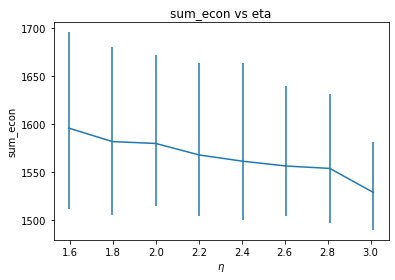

In [13]:
x=df_nodes['tc_eta']
y=df_nodes['sum']
        
nbins=8
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.ylabel('sum_econ')
plt.xlabel(r'$\eta$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])
plt.title('sum_econ vs eta');


Text(0.5, 1.0, 'sim energy vs eta')

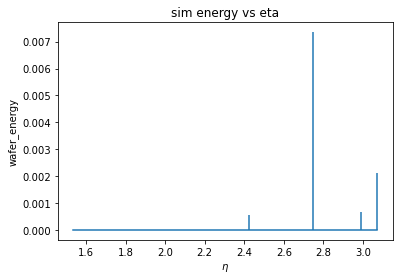

In [14]:
x=df_nodes['tc_eta']
y=df_nodes['wafer_energy']
        
nbins=20
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.ylabel('wafer_energy')
plt.xlabel(r'$\eta$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])
plt.title('sim energy vs eta')


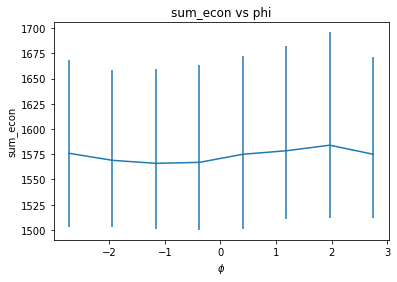

In [15]:
x=df_nodes['tc_phi']
y=df_nodes['sum']
        
nbins=8
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.ylabel('sum_econ')
plt.xlabel(r'$\phi$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])
plt.title('sum_econ vs phi');

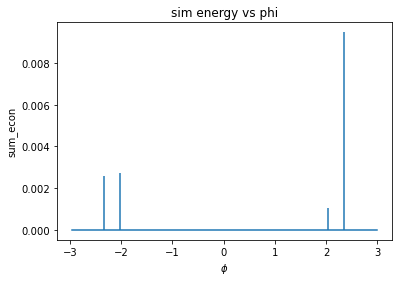

In [16]:
x=df_nodes['tc_phi']
y=df_nodes['wafer_energy']
        
nbins=20
lims=None
stats=True
if lims==None: lims = (x.min(),x.max())
median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
median = np.nan_to_num(median_result.statistic)
hi = np.nan_to_num(hi_result.statistic)
lo = np.nan_to_num(lo_result.statistic)
hie = hi-median
loe = median-lo
bin_edges = median_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.ylabel('sum_econ')
plt.xlabel(r'$\phi$')
plt.errorbar(x=bin_centers, y=median, yerr=[loe,hie])
plt.title('sim energy vs phi');

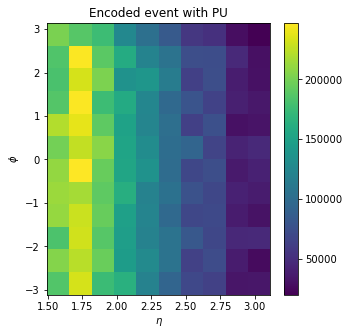

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
h = ax.hist2d(x=df_nodes['tc_eta'],y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['sum'])
fig.colorbar(h[3], ax=ax)
plt.xlabel(r'$\eta$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event with PU');

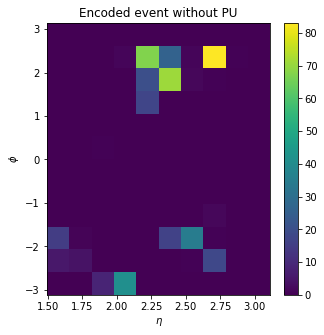

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
h = ax.hist2d(x=df_nodes['tc_eta'],y=df_nodes['tc_phi'],bins=(10,12),weights=df_nodes['wafer_energy'])
fig.colorbar(h[3], ax=ax)
plt.xlabel(r'$\eta$');
plt.ylabel(r'$\phi$');
plt.title('Encoded event without PU');

electron was shot from eta: 2.56, phi: 	-1.5370439

